# KSA: Polar Observations and Modelling

## Week 5 - Hydrographic sections

Now that we know how to build and plot hydrographic cross sections, lets look at what has happened with the Antarctic Bottom Water layer in the Australian basin.

If you are curious about this water mass and why do we care, check out [link](link).

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr

# Identifying the AABW layer

Let's open the historic occupations, and merge with the latest one that we created in `1_Building_a _cross_section.ipynb`:

In [2]:
I09S = xr.open_dataset('data/i09s.nc')
I09S_2024 = xr.open_dataset('data/i09s_2024.nc')
I09S = xr.concat([I09S, I09S_2024], dim = 'gridded_section')

Now we need to be able to identify the AABW layer. Water masses are usually defined by their properties: temperature, salinity, density, etc. For example, in the Southern Ocean, Circumpolar Deep Water is that water warmer than 1.5C.

AABW is defined by a specific value of *neutral density*, 28.30 kg/m$^3$. Neutral density, also referred to as $\gamma$ is calculated by referrencing potential density surfaces to hydrographic data, and their use is widespread. It's calculation is not trivial, so for the sake of this tutorial, we will provide you neutral densities calculated for I09S. They are in `data/i09s_neutral_density.nc`

In [3]:
neutral_density = xr.open_dataset('data/i09s_neutral_density.nc')

To keep everything nice and tidy let's add it to our I09S dataset:

In [4]:
I09S = xr.merge([I09S, neutral_density])

Amazing. Now we are all set with a dataset complete with all the variables we need!

Let's plot a cross section with the 28.30 kg/m$^3$ contour using a different colour for each year to see what's been happening with the AABW layer. I will define a colour for each year, labels for the years, a land mask to plot the land in black, and a lengend_entry to reference each line.

In [5]:
colours = ['steelblue', 'lightskyblue', 'darkorange', 'red']
years = ['1995', '2004', '2012', '2024']
land_mask = xr.where(np.isnan(I09S['temperature'].isel(gridded_section = 0).squeeze()), 1, np.nan)
legend_entry = [mlines.Line2D([], [], color = 'steelblue', label = '1995', linewidth = 2.5),
                mlines.Line2D([], [], color = 'lightskyblue', label = '2004', linewidth = 2.5),
                mlines.Line2D([], [], color = 'darkorange', label = '2012', linewidth = 2.5),
                mlines.Line2D([], [], color = 'red', label = '2024', linewidth = 2.5)]

Let's select the basin:

In [10]:
I09S_south_basin = I09S.sel(latitude = slice(-62, -50))
land_mask_south_basin = land_mask.sel(latitude = slice(-62, -50))

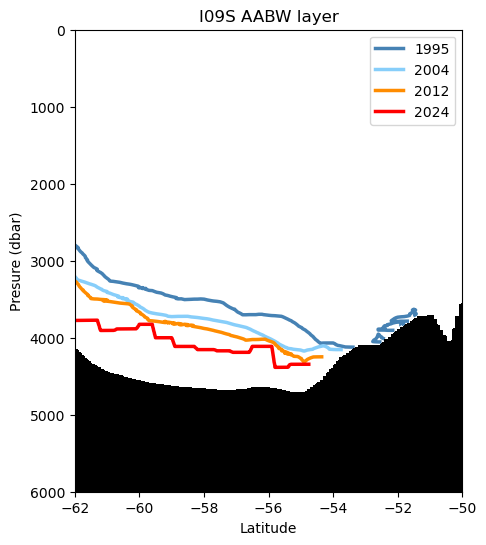

In [11]:
plt.figure(figsize = (5,6))
for t in range(0, len(I09S['gridded_section'])):
    I09S_south_basin['gamma'].isel(gridded_section = t).squeeze().plot.contour(levels = [28.30], colors = colours[t],
                                                                                linewidths = [2.5])

plt.legend(handles = legend_entry)
land_mask_south_basin.plot.contourf(colors = ['k'], add_colorbar = False, zorder = 4)
plt.gca().invert_yaxis()
plt.title('I09S AABW layer')
plt.xlabel('Latitude')
plt.ylabel('Presure (dbar)');
plt.ylim(6000, None);

As you can see, the AABW has contracted in each subsequent occupation, symptomatic of reduced formation and overturning as a consequence of climate warming. As AABW flows at the bottom of the ocean, it's circulation pathways are greatly limited by topography. As an example, look at this figure, from [van Wijk, E. M. and & Rintoul, S. R. (2014)](9https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2013GL058921):

![](../images/AABW_pathways.jpg)



You can see how after circulating in the deep Australian Antarctic Basin, some AABW escapes northwards through a gap in the ridge. 

Along it's journey, AABW will suffer changes in its properties: mixing with ambient, less dense, waters will reduce its density. So to see what happens to AABW outside of the Australian Antarctic Basin, let's define it by a somewhat reduced value of neutral density (28.2 kg/m$^3$).

In [17]:
I09S_north_basin = I09S.sel(latitude = slice(-48, -35))
land_mask_north_basin = land_mask.sel(latitude = slice(-48, -35))

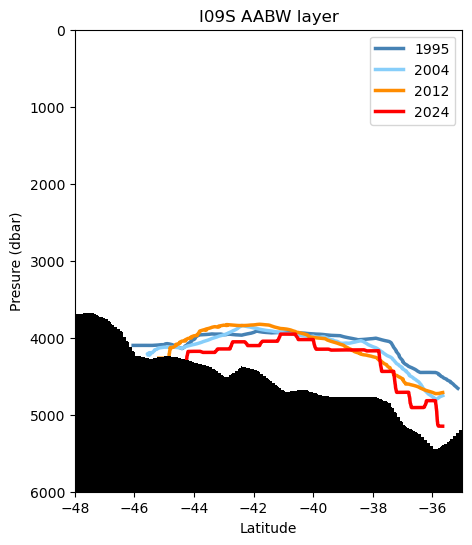

In [18]:
plt.figure(figsize = (5,6))
for t in range(0, len(I09S['gridded_section'])):
    I09S_north_basin['gamma'].isel(gridded_section = t).squeeze().plot.contour(levels = [28.20], colors = colours[t],
                                                                                linewidths = [2.5])

plt.legend(handles = legend_entry)
land_mask_north_basin.plot.contourf(colors = ['k'], add_colorbar = False, zorder = 4)
plt.gca().invert_yaxis()
plt.title('I09S AABW layer')
plt.xlabel('Latitude')
plt.ylabel('Presure (dbar)');
plt.ylim(6000, None);

The contraction is harder to visualize here, but it does seem that the layer has contracted in 2024.

# Quantifying changes

We can calculate the actual area occupied by AABW to put a number to the changes. In order to do this, we need to integrate all the area where neutral densities are higher than 28.30 kg/m$^3$.

Because we have gridded data, what we can do is sum the area of all gridcells with neutral densities larger than 28.30 kg/m$^3$. In the schematic below, those would be the dark purple gridcells. 

![](../images/grid_schematic.png)

Our first step is to calculate a $dz$ from the vertical axis, which is in pressure units. So we need to convert that pressure to depth. We will use `gsw`!

Note: we need to multiply by -1 to get positive depths.

In [167]:
depth = gsw.z_from_p(I09S_south_basin['pressure'], I09S_south_basin['latitude']).rename('depth')
depth = -1 * depth 

To calculate $dz$ from our depth array, we can use the `xarray.diff()` function, which calculates the difference between subsequent points in an array along the specified dimension, so that:
$$
dz_{i+1} = z_{i+1} - z_{i}
$$

Notice how our $dz$ can not have a value at surface because there is no $z_{-1}$! We need to remember this in a future step.

In [168]:
dz = depth.diff(dim = 'pressure')
dz

<xarray.DataArray 'depth' (pressure: 650, latitude: 121)>
array([[9.90393821, 9.90401416, 9.90409028, ..., 9.91386623, 9.91395629,
        9.91404641],
       [9.90345737, 9.90353332, 9.90360944, ..., 9.91338489, 9.91347494,
        9.91356505],
       [9.90297668, 9.90305262, 9.90312874, ..., 9.9129037 , 9.91299375,
        9.91308385],
       ...,
       [9.62188948, 9.62196316, 9.62203701, ..., 9.63152102, 9.63160839,
        9.63169581],
       [9.62149543, 9.62156911, 9.62164296, ..., 9.63112656, 9.63121392,
        9.63130134],
       [9.62110151, 9.62117518, 9.62124903, ..., 9.63073222, 9.63081958,
        9.63090699]])
Coordinates:
  * pressure  (pressure) float64 10.0 20.0 30.0 ... 6.48e+03 6.49e+03 6.5e+03
  * latitude  (latitude) float64 -62.0 -61.9 -61.8 -61.7 ... -50.2 -50.1 -50.0

Now let's calculate our $dx$. We have latitude coordinates in our I09S array, so we will need to convert that to m. In the case of latitude $/rightarrow$ distance it is easy because it is a constant value everywhere:
$$
dx \sim 111000m \times d(latitude)
$$

In [169]:
dx = 111000 * 0.1

#### Question 1

What do you think we need to take into account for if we want to calculate a distance between two *longitude* points instead?

*Answer here*

Now we can calculate our area: $area = dx \times dz$

In [170]:
area = dx * dz
area = area.rename('area')

What we want to do now is select the region in our `area` array and sum it to obtain the total area of the AABW layer. We can do that by (i) creating a mask that identifies the gridboxes with AABW density values, (ii) applying that mask to the `area` array and (iii) finally summing. 

We will create a mask that has 1s for regions with AABW, `NaN`s everywhere else.

In [171]:
AABW_layer_mask = xr.where(I09S_south_basin['gamma'] >= 28.30, 1, np.nan).rename('mask')
AABW_layer_mask

<xarray.DataArray 'mask' (pressure: 651, latitude: 121, longitude: 1,
                          gridded_section: 4)>
array([[[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]],


       [[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],
...
        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]],


       [[[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        ...,

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]],

        [[nan, nan, nan, nan]]]])
Coordinates:
  * gridded_section  (gridded_section) float64 1.0 2.0 3.0 4.0
  * longitude        (longitude) float64 114.7
  * latitude         (latitude) float64 -62.0 -61.9 -61.8 ... -50.2 -50.1 -50.0
  * pressure         (pressure) float64 0.0 10.0 20.0 ... 6.49e+03 6.5e+03

In [172]:
AABW_layer_areas = AABW_layer_mask * area

Let's verify we have selected the correct regions:

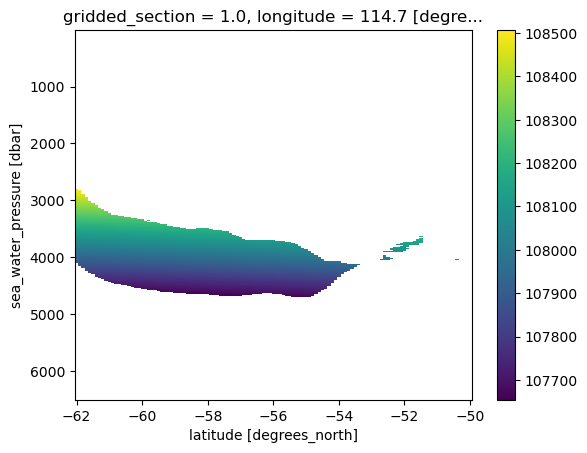

In [173]:
AABW_layer_areas.squeeze().isel(gridded_section = 0).plot()
plt.gca().invert_yaxis()

Now let's sum (integrate) to get our total layer:

In [174]:
AABW_area = AABW_layer_areas.sum(['latitude', 'pressure']).squeeze().rename('AABW_area')
AABW_area.attrs['units'] = 'm2'

Let's plot!

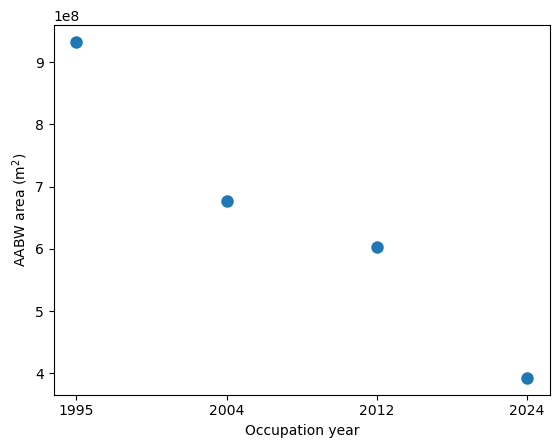

In [175]:
AABW_area.plot.scatter(s = 100);
plt.ylabel('AABW area (m$^2$)')
plt.xticks([1,2,3,4], years)
plt.xlabel('Occupation year');
plt.title('');

#### Question 2

Now calculate the average temperature, salinity and oxygen in the AABW. Plot these three together with the area of the layer in the same figure, with four different panels. 

Try to get the following figure:

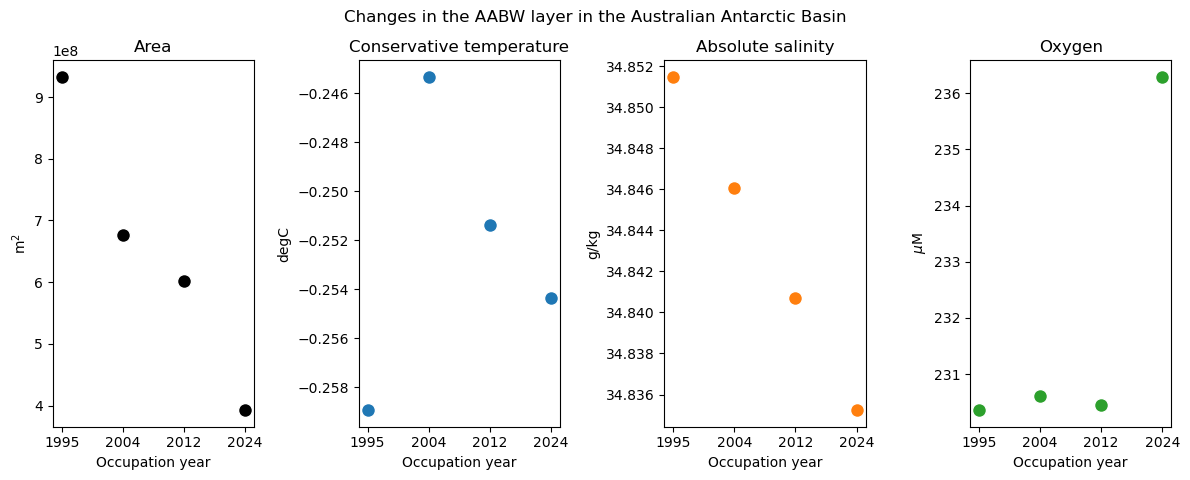

In [178]:
fig = plt.figure(figsize = (12,5))
axs = [fig.add_subplot(141), fig.add_subplot(142), 
       fig.add_subplot(143), fig.add_subplot(144)]

AABW_area.plot.scatter(ax = axs[0], s = 100, c = 'k');
AABW_temp.plot.scatter(ax = axs[1], s = 100, c = 'C0');
AABW_salt.plot.scatter(ax = axs[2], s = 100, c = 'C1');
AABW_oxyg.plot.scatter(ax = axs[3], s = 100, c = 'C2');

for ax in axs:
       ax.set_xticks([1,2,3,4], years)
       ax.set_xlabel('Occupation year');

axs[0].set_ylabel('m$^{2}$')
axs[0].set_title('Area')
axs[1].set_ylabel('degC')
axs[1].set_title('Conservative temperature')
axs[2].set_ylabel('g/kg')
axs[2].set_title('Absolute salinity')
axs[3].set_ylabel('$\mu$M')
axs[3].set_title('Oxygen');
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle('Changes in the AABW layer in the Australian Antarctic Basin');

Note: the area of each gridbox is different, so to make this calculation accurate you will have to calculate a weighted average, using the area of the gridboxes as cells!

You can use [CoPilot](https://copilot.microsoft.com/) to help you!

#### Question 3

Repeat the calculations for the basin north of the ridge (our `I09S_north_basin`). Think about the following questions:

**a.** How are the changes different from the southern basin? Look at the magnitudes!
 
**b.** What do you think these differences are attributed to?

*Answer here*